# **AUDIO SIGNAL ANALYSIS USING MACHINE LEARNING**

## **Virtualize normal/abnormal heart sounds and their corresponding MFCCs**

In [2]:
import librosa, librosa.display, IPython.display, time, pywt
import numpy as np, pandas as pd, keras.backend as K, matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import Callback
%matplotlib inline

Using TensorFlow backend.


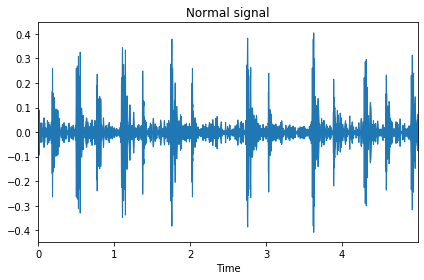

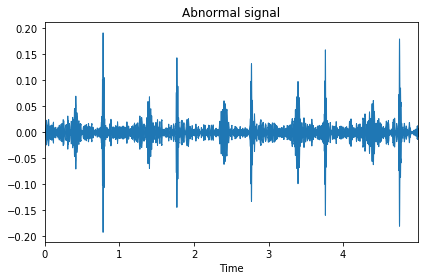

In [2]:
## Display a normal heart sound and an abnormal heart sound

# Load and display normal file
normal_x, normal_fs = librosa.load('./normal/a0007.wav')
normal_x = normal_x[:5*normal_fs]
librosa.display.waveplot(normal_x, sr=normal_fs)
plt.title('Normal signal')
plt.tight_layout()
plt.show()
IPython.display.display(IPython.display.Audio(normal_x, rate=normal_fs))

# Load and display abnormal file
abnormal_x, abnormal_fs = librosa.load('./abnormal/a0001.wav')
abnormal_x = abnormal_x[:5*abnormal_fs]
librosa.display.waveplot(abnormal_x, sr=abnormal_fs)
plt.title('Abnormal signal')
plt.tight_layout()
plt.show()
IPython.display.display(IPython.display.Audio(abnormal_x, rate=abnormal_fs))

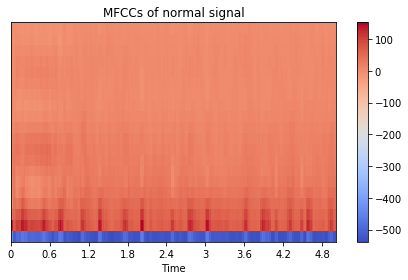

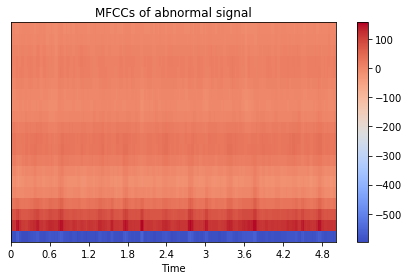

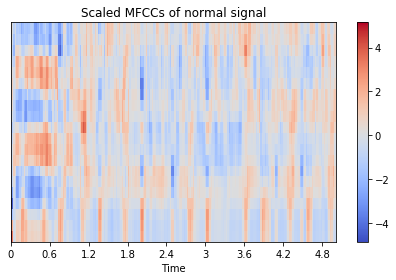

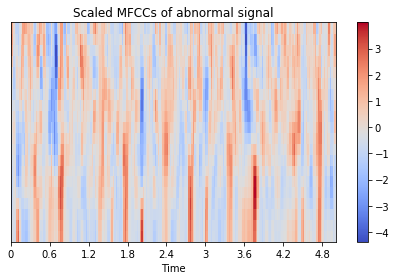

In [3]:
## Virtualize MFCCs of a normal and an abnormal audio

# Get MFCCs of a normal signal and display
normal_mfccs = librosa.feature.mfcc(normal_x, sr=normal_fs)
librosa.display.specshow(normal_mfccs, sr=normal_fs, x_axis='time')
plt.colorbar()
plt.title('MFCCs of normal signal')
plt.tight_layout()
plt.show()

# Get MFCCs of an abnormal signal and display
abnormal_mfccs = librosa.feature.mfcc(abnormal_x, sr=abnormal_fs)
librosa.display.specshow(abnormal_mfccs, sr=abnormal_fs, x_axis='time')
plt.colorbar()
plt.title('MFCCs of abnormal signal')
plt.tight_layout()
plt.show()


# Scale the MFCCs such that each coefficient dimension
# has zero mean and unit variance

# Normal signal
normal_mfccs = scale(normal_mfccs, axis=1)
librosa.display.specshow(normal_mfccs, sr=normal_fs, x_axis='time')
plt.colorbar()
plt.title('Scaled MFCCs of normal signal')
plt.tight_layout()
plt.show()


# Abnormal signal
abnormal_mfccs = scale(abnormal_mfccs, axis=1)
librosa.display.specshow(abnormal_mfccs, sr=abnormal_fs, x_axis='time')
plt.colorbar()
plt.title('Scaled MFCCs of abnormal signal')
plt.tight_layout()
plt.show()

## **Reduce MFCCs to 2D by tSNE**

In [2]:
## Functions to read dataset and extract features

def extract_feature(file,feat='mfcc',flt=True,nMFCC=96,flatten=True,mean=False):
    # nMFCC, flatten, mean only apply when feat='mfcc'
    
    def butter_bandpass_filter(data, fs, lowcut=25, highcut=400, order=5):
        nyq = 0.5*fs
        low = lowcut/nyq
        high = highcut/nyq
        b, a = butter(order, [low, high], btype='band')
        y = lfilter(b, a, data)
        return y

    # Load data and pre-process
    data, rate = librosa.load(file, sr=None)
    data = data[:5*rate]
    
    if flt:
        data = butter_bandpass_filter(data, rate)
    
    if feat == 'mfcc':
        if flatten:
            return librosa.feature.mfcc(y=data,sr=rate,n_mfcc=nMFCC).flatten()
        else:
            data = librosa.resample(data, rate, 22050)
            mfcc = librosa.feature.mfcc(y=data, n_mfcc=nMFCC)
            if mean:
                return np.mean(mfcc.T,axis=0)
            else:
                return mfcc
            
    elif feat == 'spamp':
        return abs(np.fft.rfft(data))
    
    elif feat == 'wavelet':
        cA, cD = pywt.dwt(data, 'db1')
        return cD
    
    elif feat == 'mfcc-dwt':
        data = librosa.resample(data, rate, 22050)
        mfcc = np.mean((librosa.feature.mfcc(y=data, n_mfcc=nMFCC)).T,axis=0)
        cA, cD = pywt.dwt(data, 'db1')
        return np.concatenate((mfcc, cD))
    
    elif feat == 'raw':
        return data
    
    else:
        raise ValueError('Invalid second argument')
        
        
def read_dataset(dataset,feat='mfcc',flt=True,nMFCC=96,flatten=True,mean=False):
    def read_dir(dir_path,feat='mfcc',flt=True,nMFCC=96,flatten=True,mean=False):
        # Read REFERENCE.csv
        if dir_path[-1] == '/':
            dir_path = dir_path[:-1]
        csv_path = dir_path + '/REFERENCE.csv'
        df = pd.read_csv(csv_path, header=None)
        features = []
        labels = []
        N = df.shape[0]

        for i in range(N):
            wav_path = dir_path +'/' + df.iat[i,0] + '.wav'
            features.append(extract_feature(wav_path,feat,flt,nMFCC,flatten,mean))
            if df.iat[i,1] == 1:
                labels.append(1) # abnormal
            else:
                labels.append(0) # normal

        return features, labels
    
    if dataset[-1] == '/':
        dataset = dataset[:-1]
       
    # Read dataset
    data_a, labels_a = read_dir(dataset+'/training-a',feat,flt,nMFCC,flatten,mean)
    data_b, labels_b = read_dir(dataset+'/training-b',feat,flt,nMFCC,flatten,mean)
    data_c, labels_c = read_dir(dataset+'/training-c',feat,flt,nMFCC,flatten,mean)
    data_d, labels_d = read_dir(dataset+'/training-d',feat,flt,nMFCC,flatten,mean)
    data_e, labels_e = read_dir(dataset+'/training-e',feat,flt,nMFCC,flatten,mean)
    data_f, labels_f = read_dir(dataset+'/training-f',feat,flt,nMFCC,flatten,mean)
    
    data = np.concatenate((data_a, data_b, data_c, data_d, \
                            data_e, data_f))
    labels = np.concatenate((labels_a, labels_b, labels_c, labels_d, \
                             labels_e, labels_f))
    
    return data, labels

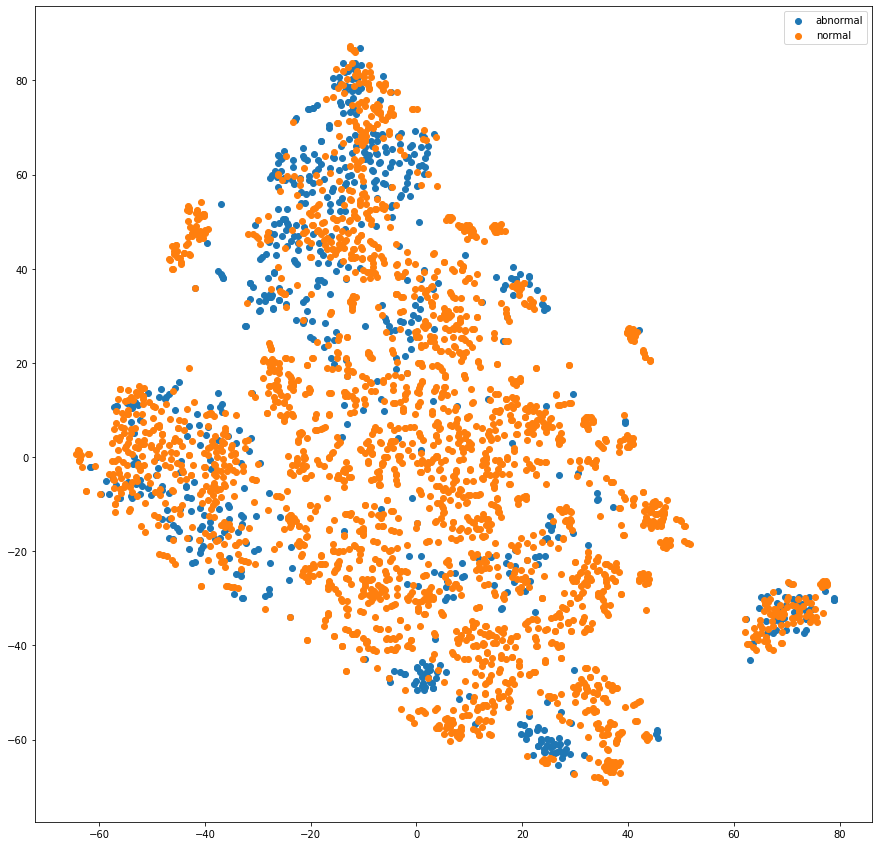

In [5]:
## Reduce MFCCs to 2D by TSNE

from sklearn.manifold import TSNE

# read dataset
mfcc, label = read_dataset('./')

# compile model
tsne_model = TSNE().fit_transform(mfcc)

# Virtualize model
plt.figure(figsize = (15,15))

plt.scatter(tsne_model[label==1,0], tsne_model[label==1,1])

plt.scatter(tsne_model[label==0,0], tsne_model[label==0,1])

plt.legend(['abnormal', 'normal'])
#plt.savefig('./result.png')
plt.show()

## **Heart sound classification: KNN**

In [3]:
def train_KNN(features, labels, n=5):
    
    # Split training and validation sets
    train_feat,test_feat,train_lab,test_lab = train_test_split(features,\
                                                               labels, test_size=0.3)     
    
    # Train model
    model = KNeighborsClassifier(n_neighbors=n).fit(train_feat, train_lab)

    # Predict the response for test dataset
    test_pred = model.predict(test_feat)

    # Model Accuracy, Precision, Recall, F score
    accuracy = accuracy_score(test_lab, test_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(\
                        test_lab, test_pred, average='binary')
    print("\tAccuracy:\t", round(accuracy, 2))
    print("\tPrecision:\t", round(precision, 2))
    print("\tRecall:\t\t", round(recall, 2))
    print("\tF score:\t", round(fscore, 2))
    return model, accuracy, precision, recall, fscore

In [7]:
## KNN using 96 MFCCs as feature
print("KNN with 96 MFCCs")
model_mfcc96, acc_mfcc96, p_mfcc96, r_mfcc96, fscore_mfcc96 \
= train_KNN(mfcc, label)

KNN with 96 MFCCs
	Accuracy:	 0.84
	Precision:	 0.64
	Recall:		 0.42
	F score:	 0.51


In [8]:
## KNN using 40 mean MFCCs as feature
print("KNN with 40 mean MFCCs")
mfcc40, label = read_dataset('./',flt=False,nMFCC=40,flatten=False,mean=True)
model_mfcc40, acc_mfcc40, p_mfcc40, r_mfcc40, fscore_mfcc40 \
= train_KNN(mfcc40, label)

KNN with 40 mean MFCCs
	Accuracy:	 0.88
	Precision:	 0.75
	Recall:		 0.68
	F score:	 0.71


In [9]:
## KNN using spectral amplitude as feature
print("KNN with spectral amplitudes")
spamp, label = read_dataset('./', feat='spamp')
model_spamp, acc_spamp, p_spamp, r_spamp, fscore_spamp\
= train_KNN(spamp, label)

KNN with spectral amplitudes
	Accuracy:	 0.8
	Precision:	 0.46
	Recall:		 0.4
	F score:	 0.43


In [10]:
## KNN using wavelet features
print("KNN with wavelet features")
wavelet, label = read_dataset('./', feat='wavelet')
model_wavelet, acc_wavelet, p_wavelet, r_wavelet, fscore_wavelet\
= train_KNN(wavelet, label)

KNN with wavelet features
	Accuracy:	 0.7
	Precision:	 0.15
	Recall:		 0.1
	F score:	 0.12


In [11]:
## KNN using both MFCC and wavelet features
print("KNN with both 40 mean MFCCs and DWT")
mfcc_dwt, label = read_dataset('./', feat='mfcc-dwt')
model_all, acc_all, p_all, r_all, fscore_all = train_KNN(mfcc_dwt, label)

KNN with both 40 mean MFCCs and DWT
	Accuracy:	 0.85
	Precision:	 0.61
	Recall:		 0.54
	F score:	 0.57


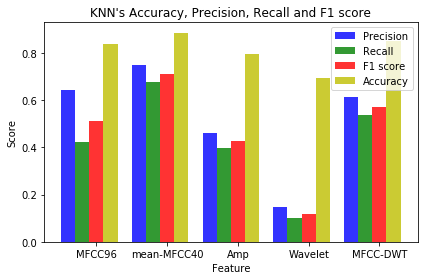

In [12]:
## Plot Accuracy, Precision, Recall and F1 score

# data to plot
n_groups = 5
objects = ('MFCC96', 'mean-MFCC40', 'Amp', 'Wavelet', 'MFCC-DWT')
A = (acc_mfcc96,acc_mfcc40,acc_spamp,acc_wavelet,acc_all)
P = (p_mfcc96,p_mfcc40,p_spamp,p_wavelet,p_all)
R = (r_mfcc96,r_mfcc40,r_spamp,r_wavelet,r_all)
F = (fscore_mfcc96,fscore_mfcc40,fscore_spamp,fscore_wavelet,fscore_all)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, P, bar_width, \
                 alpha=opacity, color='b', label='Precision')

rects2 = plt.bar(index + bar_width, R, bar_width, \
                 alpha=opacity, color='g', label='Recall')

rects3 = plt.bar(index + bar_width*2, F, bar_width, \
                 alpha=opacity, color='r', label='F1 score')

rects4 = plt.bar(index + bar_width*3, A, bar_width, \
                 alpha=opacity, color='y', label='Accuracy')

plt.xlabel('Feature')
plt.ylabel('Score')
plt.title('KNN\'s Accuracy, Precision, Recall and F1 score')
plt.xticks(index + bar_width*2, objects)
plt.legend()

plt.tight_layout()
plt.savefig('KNN.png')
plt.show()

KNN with mean 40-MFCC has the highest performance. Therefore, we try to optimize KNN model with these features

In [3]:
mfcc40, label = read_dataset('./',flt=False,nMFCC=40,flatten=False,mean=True)
X_train,X_test,y_train,y_test = train_test_split(mfcc40, label, test_size=0.3)

In [4]:
# Grid Search to optimize hyperparameter
parameters = {'n_neighbors':[3,5,7,9,11,13],
             'weights':['uniform','distance'],
              'algorithm':['auto','ball_tree','kd_tree'],
              'p':[1,2,3],
              'n_jobs':[-1]
             }

model = GridSearchCV(KNeighborsClassifier(), param_grid=parameters)
model.fit(X_train,y_train)

print('Best Score:\t', model.best_score_)
print('Best Params:\t', model.best_params_)

/home/tracy/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score:	 0.8994708994708994
Best Params:	 {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [5]:
## Apply these hyperparameters
print("KNN with 40 mean MFCCs (optimized)")
    
# Train model
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='auto',
                           p=1, n_jobs=-1).fit(X_train, y_train)

# Predict the response for test dataset
y_pred = model.predict(X_test)

# Model Accuracy, Precision, Recall, F score
accuracy = accuracy_score(y_test, y_pred)
precision, recall, fscore, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary')
print("\tAccuracy:\t", round(accuracy, 2))
print("\tPrecision:\t", round(precision, 2))
print("\tRecall:\t\t", round(recall, 2))
print("\tF score:\t", round(fscore, 2))

KNN with 40 mean MFCCs (optimized)
	Accuracy:	 0.89
	Precision:	 0.76
	Recall:		 0.71
	F score:	 0.74


## **Heart sound classification: CNN**

In [3]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.asarray(self.model.predict(self.validation_data[0])).round()
        val_predict = np.argmax(val_predict, axis=1)
        val_targ = np.argmax(self.validation_data[1], axis=1)
        _val_precision, _val_recall, _val_f1, _ = \
        precision_recall_fscore_support(val_targ, val_predict, average='binary')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" \
              %(_val_f1, _val_precision, _val_recall))
        return

    
def prepare_2D(X, Y):
    X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    Y = to_categorical(Y)
    # split training and validation sets
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3)
    xtest, xvalid, ytest, yvalid = train_test_split(xtest, ytest, test_size=0.5)
    
    return xtrain, xvalid, xtest, ytrain, yvalid, ytest


def prepare_1D(X, Y):
    X = X.reshape(X.shape[0],X.shape[1],1)
    Y = to_categorical(Y)
    
    # split training and validation sets
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3)
    xtest, xvalid, ytest, yvalid = train_test_split(xtest, ytest, test_size=0.5)
    
    return xtrain, xvalid, xtest, ytrain, yvalid, ytest


    
def plot_history(history, name='CNN'):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title(name+' loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation fscore values
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set_title(name+' Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    fig.savefig(name+'-history.png')
    
    
def plot_metrics(metrics,name='CNN'):
    fig, axs = plt.subplots(1, 3, figsize=(25,5))
    
    # Plot validation fscore values
    axs[0].plot(metrics.val_f1s)
    axs[0].set_title(name+' Validation Fscore')
    axs[0].set_ylabel('Fscore')
    axs[0].set_xlabel('Epoch')
    
    # Plot validation recall values
    axs[1].plot(metrics.val_recalls)
    axs[1].set_title(name+' Validation Recall')
    axs[1].set_ylabel('Recall')
    axs[1].set_xlabel('Epoch')
    
    # Plot validation precision values
    axs[2].plot(metrics.val_precisions)
    axs[2].set_title(name+' Validation Precision')
    axs[2].set_ylabel('Precision')
    axs[2].set_xlabel('Epoch')
    
    fig.savefig(name+'-metrics.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 39, 215, 16)       80        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 19, 107, 16)       0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 19, 107, 16)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 18, 106, 32)       2080      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 9, 53, 32)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 9, 53, 32)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 52, 64)         8256      
__________

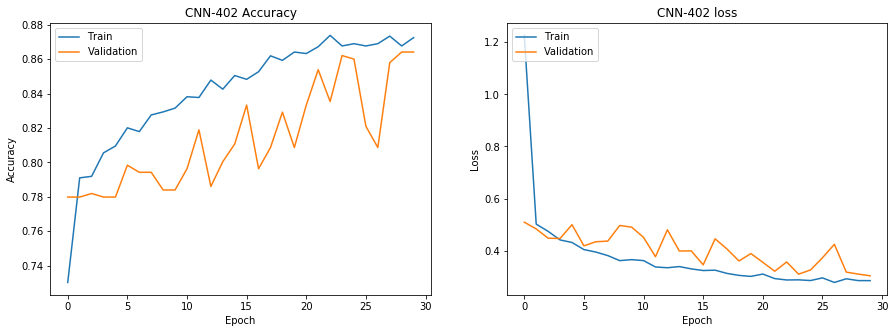

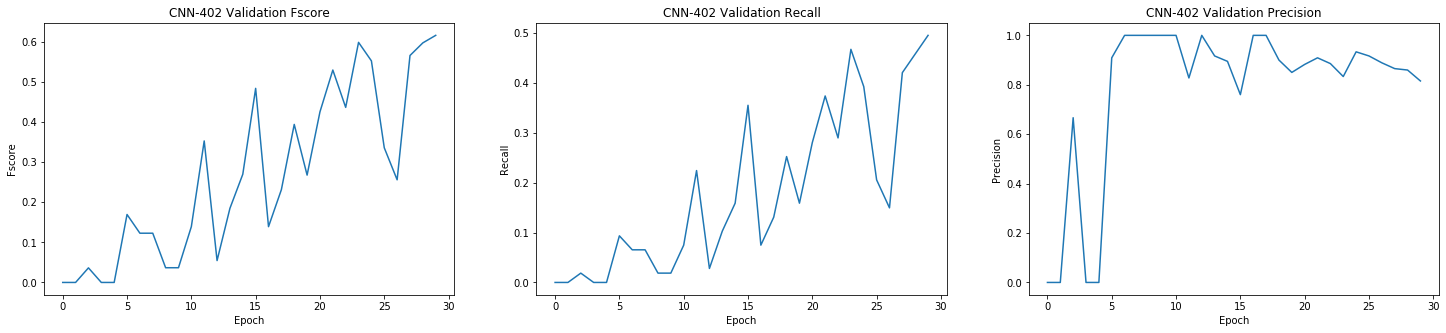

In [13]:
## 2D CNN - 40 mean MFCCs
mfcc402, label = read_dataset('./',flt=False,nMFCC=40,flatten=False)

xtrain402,xvalid402,xtest402,ytrain402,yvalid402,ytest402 = prepare_2D(mfcc402,label)
    
# create model
model402 = Sequential()

# add model layers
model402.add(Conv2D(16, kernel_size=2, activation='relu',
                   input_shape=(xtrain402.shape[1],xtrain402.shape[2],1)))
model402.add(MaxPooling2D(pool_size=2))
model402.add(Dropout(0.2))

model402.add(Conv2D(32, kernel_size=2, activation='relu'))
model402.add(MaxPooling2D(pool_size=2))
model402.add(Dropout(0.2))

model402.add(Conv2D(64, kernel_size=2, activation='relu'))
model402.add(MaxPooling2D(pool_size=2))
model402.add(Dropout(0.2))

model402.add(GlobalAveragePooling2D())
model402.add(Dense(2, activation='softmax'))
    
# compile
model402.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model402.summary()

# train model
metrics402 = Metrics()
history402 = model402.fit(xtrain402, ytrain402, validation_data=(xvalid402, yvalid402),
                        epochs=30, callbacks=[metrics402], verbose=2)

plot_history(history402, 'CNN-402')
plot_metrics(metrics402, 'CNN-402')

print(classification_report(np.argmax(ytest402,axis=1),
                      np.argmax(model402.predict(xtest402),axis=1)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 39, 16)            48        
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 19, 16)            0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 19, 16)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 18, 32)            1056      
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 9, 32)             0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 9, 32)             0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 8, 64)             4160      
__________

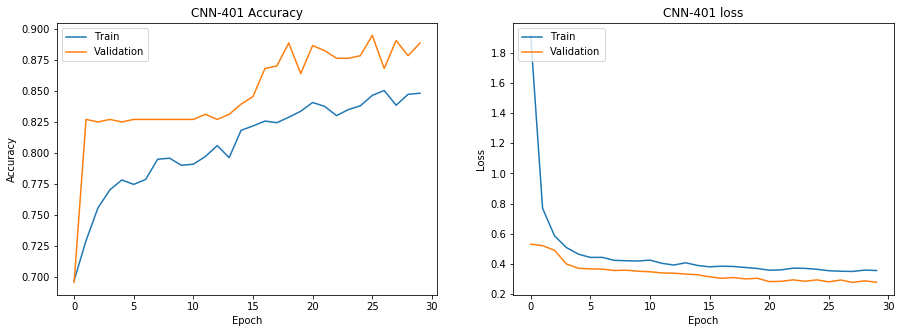

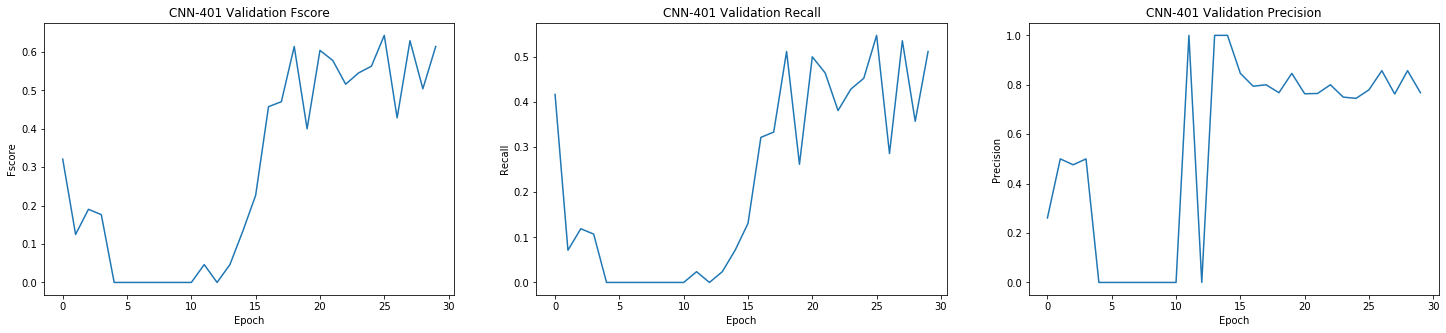

In [21]:
## 1D CNN - 40 mean MFCCs
mfcc40, label = read_dataset('./',flt=False,nMFCC=40,flatten=False,mean=True)

xtrain40,xvalid40,xtest40,ytrain40,yvalid40,ytest40 = prepare_1D(mfcc40,label)
    
# create model
model40 = Sequential()

# add model layers
model40.add(Conv1D(16, kernel_size=2, activation='relu',
                   input_shape=(xtrain40.shape[1],1)))
model40.add(MaxPooling1D(pool_size=2))
model40.add(Dropout(0.2))

model40.add(Conv1D(32, kernel_size=2, activation='relu'))
model40.add(MaxPooling1D(pool_size=2))
model40.add(Dropout(0.2))

model40.add(Conv1D(64, kernel_size=2, activation='relu'))
model40.add(MaxPooling1D(pool_size=2))
model40.add(Dropout(0.2))

model40.add(Conv1D(128, kernel_size=2, activation='relu'))
model40.add(MaxPooling1D(pool_size=2))
model40.add(Dropout(0.2))

model40.add(GlobalAveragePooling1D())
model40.add(Dense(2, activation='softmax'))
    
# compile
model40.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model40.summary()

# train model
metrics40 = Metrics()
history40 = model40.fit(xtrain40, ytrain40, validation_data=(xvalid40, yvalid40),
                        epochs=30, callbacks=[metrics40], verbose=2)

plot_history(history40, 'CNN-401')
plot_metrics(metrics40, 'CNN-401')

print(classification_report(np.argmax(ytest40,axis=1),
                      np.argmax(model40.predict(xtest40),axis=1)))

## **Heart sound classification: LSTM**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 40, 64)            16896     
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 29,378
Trainable params: 29,378
Non-trainable params: 0
_________________________________________________________________
Train on 2268 samples, validate on 486 samples
Epoch 1/100
 - 5s - loss: 0.4816 - acc: 0.7725 - val_loss: 0.3602 - val_acc: 0.8251
 — val_f1: 0.190476 — val_precision: 0.769231 — val_recall: 0.108696
Epoch 2/100
 - 3s - loss: 0.3980 - acc: 0.8117 - val_loss: 0.3355 - val_acc: 0.8580
 — val_f1: 0.622951 — val_precision: 0.626374 — val_recall: 0.619565
Epoch 3/100
 - 3s - loss: 0.3781 - acc: 0.8289 - 

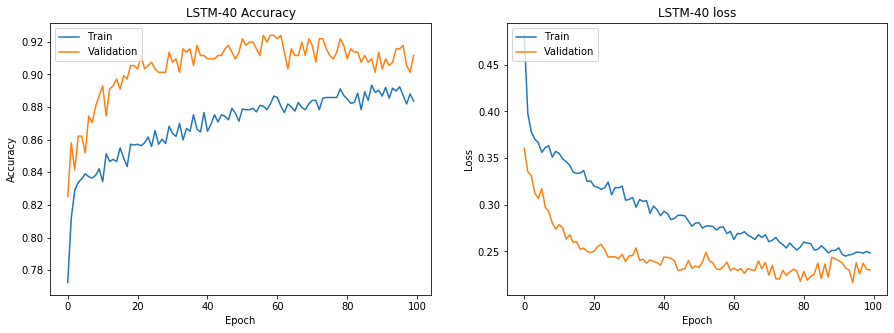

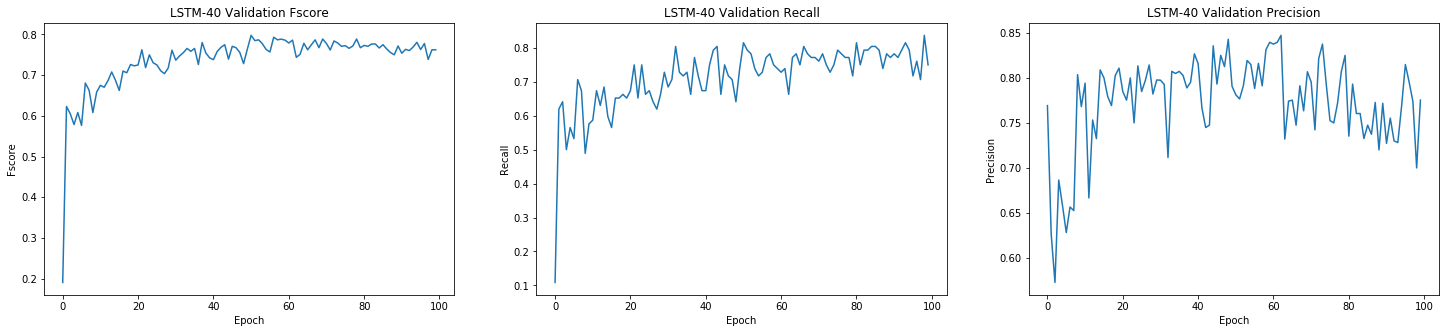

In [12]:
## LSTM - 40 mean MFCCs
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, 
               return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20,return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adamax',metrics=['acc'])
model.summary()

xtrain,xvalid,xtest,ytrain,yvalid,ytest = prepare_1D(mfcc40,label)

metrics = Metrics()
history = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid),
                    epochs=100, callbacks=[metrics], verbose=2)

plot_history(history, 'LSTM-40')
plot_metrics(metrics, 'LSTM-40')

print(classification_report(np.argmax(ytest,axis=1),
                      np.argmax(model.predict(xtest),axis=1)))

In [ ]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

In [ ]:
#import dill
#dill.dump_session('notebook_session.db')
#import dill
#dill.load_session('notebook_session.db')
#model.summary()

In [5]:
%store mfcc402
%store mfcc40
%store label

Optimize LSTM

In [19]:
from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe

def data():
    import librosa
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from keras.utils import to_categorical
    def extract_feature(file):
        # Load data and pre-process
        data, rate = librosa.load(file)
        data = data[:5*rate]
        mfcc = librosa.feature.mfcc(y=data, n_mfcc=40)
        return np.mean(mfcc.T,axis=0)

    def read_dir(dir_path,feat='mfcc'):
        # Read REFERENCE.csv
        if dir_path[-1] == '/':
            dir_path = dir_path[:-1]
        csv_path = dir_path + '/REFERENCE.csv'
        df = pd.read_csv(csv_path, header=None)
        features = []
        labels = []
        N = df.shape[0]
        for i in range(N):
            wav_path = dir_path +'/' + df.iat[i,0] + '.wav'
            features.append(extract_feature(wav_path))
            if df.iat[i,1] == 1:
                labels.append(1) # abnormal
            else:
                labels.append(0) # normal
        return features, labels

    def read_dataset(dataset):
        if dataset[-1] == '/':
            dataset = dataset[:-1]
        # Read dataset
        data_a, labels_a = read_dir(dataset+'/training-a')
        data_b, labels_b = read_dir(dataset+'/training-b')
        data_c, labels_c = read_dir(dataset+'/training-c')
        data_d, labels_d = read_dir(dataset+'/training-d')
        data_e, labels_e = read_dir(dataset+'/training-e')
        data_f, labels_f = read_dir(dataset+'/training-f')
        data = np.concatenate((data_a, data_b, data_c, data_d, 
                               data_e, data_f))
        labels = np.concatenate((labels_a, labels_b, labels_c, 
                                 labels_d, labels_e, labels_f))
        return data, labels

    x, y = read_dataset('./')
    x = x.reshape(x.shape[0],x.shape[1],1)
    y = to_categorical(y)
    
    # split training and validation sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)
    
    return x_train, y_train, x_test, y_test


def create_model(x_train, y_train, x_test, y_test):
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    model = Sequential()
    
    model.add(LSTM(units={{choice([16,32,64,128,256])}},
                   dropout={{uniform(0, 1)}},
                   recurrent_dropout={{uniform(0, 1)}},
                   return_sequences=True,
                   input_shape = (40,1)))
    
    model.add(LSTM(units={{choice([16,32,64,128,256])}},
                   dropout={{uniform(0, 1)}},
                   recurrent_dropout={{uniform(0, 1)}},
                   return_sequences=False))
    
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}},
                  metrics=['acc'])

    result = model.fit(x_train, y_train,
              batch_size={{choice([16,32,64,128])}},
              epochs=2,
              verbose=2,
              validation_split=0.2)
    
    # get the highest validation accuracy of the training epochs
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

if __name__ == '__main__':
    best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                          notebook_name='audio_analysis-Copy3')

    print("Best params:")
    print(best_run)

>>> Imports:
#coding=utf-8

try:
    import librosa, librosa.display, IPython.display, time, pywt
except:
    pass

try:
    import numpy, pandas, keras.backend, matplotlib.pyplot as nppdKplt
except:
    pass

try:
    from scipy.signal import butter, lfilter
except:
    pass

try:
    from sklearn.preprocessing import scale
except:
    pass

try:
    from sklearn.neighbors import KNeighborsClassifier
except:
    pass

try:
    from sklearn.model_selection import train_test_split, GridSearchCV
except:
    pass

try:
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
except:
    pass

try:
    from sklearn.metrics import confusion_matrix, classification_report
except:
    pass

try:
    from keras.utils import to_categorical, plot_model
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, Flatten, Dropout, Activation
except:
    pass

try:
    from keras.layers import Conv2D, MaxPooling2D, 